In [5]:
import os
import tensorflow_addons as tfa
import librosa
import numpy as np
import pandas as pd
import torch
import torchaudio
from PIL import Image
from tensorflow import keras
import tensorflow as tf
import json
SAMPLE_RATE = 32000
SEED = 42
IMG_SIZE = 260
N_FFT = 2048
SIGNAL_LENGTH = 5  # seconds
FREQ_MIN = 500
FREQ_MAX = 15000
WIN_LENGHT = 1024
BATCH_SIZE = 128
MODEL_PATH = '/app/_data/models/Eff22/eff2_2.h5'
TEST_AUDIO_PATH = "/app/_data/test_soundscapes/"
TRAIN_AUDIO_PATH = "/app/_data/train_soundscapes/"
coord_sites = pd.read_csv("/app/_data/coord_sites.csv")
coord_sites = coord_sites[["longitude", "latitude", "site"]]
# from src.test_gen.test_gen_long import Mel_Provider, Test_Kaggle
# from src.test_gen.test_gen_long import Functions
from src.test_gen.gen import Mel_Provider, Test_Kaggle

In [6]:
from src.test_gen.gen import Functions

In [68]:
with open('/app/_data/dict_birds.json', 'r') as f:
    dict_birds = json.load(f)
dict_birds_code = {}
for i in dict_birds.keys():
    code = dict_birds[i]
    dict_birds_code[code]=i
# model = keras.models.load_model(MODEL_PATH)


# generator for mels cut

works faster

In [56]:
class Mel_Provider:
    def __init__(
        self,
        n_fft,
        win_length,
        n_mels,
        sample_rate,
        mel_image_size,
        min_frequency,
        max_frequency,
        signal_lenght,
        hop_length=None,
        norm_mel_long=False,
        device="cpu",
    ):
        self.norm_mel_long = norm_mel_long
        self._device = device
        self.signal_lenght = signal_lenght
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        if hop_length is None:
            self.hop_length = int(
                self.signal_lenght * self.sample_rate / (self.mel_image_size - 1)
            )
        else:
            self.hop_length = hop_length
        self._melspectrogram = torchaudio.transforms.MelSpectrogram(
            power=2.0,
            win_length=win_length,
            n_fft=n_fft,
            n_mels=n_mels,
            sample_rate=sample_rate,
            hop_length=self.hop_length,
            f_min=min_frequency,
            f_max=max_frequency,
        ).to(self._device)

    def msg(self, wave):
        wave = torch.tensor(wave.reshape([1, -1]).astype(np.float32)).to(self._device)
        mel_spec = self._melspectrogram(wave)[0].cpu().numpy()
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        if self.norm_mel_long:
            mel_spec = (mel_spec - mel_spec.min()) / (
                mel_spec.max() - mel_spec.min()
            )
        mel_spec.astype(np.float32)
        return mel_spec

class Test_Kaggle:
    def __init__(
        self,
        path,
        df_coord_sites,
        dict_birds,
        n_fft,
        sample_rate,
        mel_image_size,
        signal_lenght,
        mel_provider,
        norm_mel_short = True,
        hop_length=None,
        device="cpu",
    ):
        self.path = path
        self._device = device
        self.signal_lenght = signal_lenght
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        self.hop_length = int(
            self.signal_lenght * self.sample_rate / (self.mel_image_size - 1)
        )
        self.norm_mel_short = norm_mel_short
        self.mel_provider = mel_provider
        self.n_fft = n_fft
        self.df_coord_sites = df_coord_sites
        self.dict_birds = dict_birds

    def make_df(self):
        path = self.path
        list_files = []
        for filename in os.listdir(path):
            if filename.split(".")[-1] == "ogg":
                list_files.append(filename)
                call, srt = librosa.load(path + filename, sr=self.sample_rate)
                duration = librosa.get_duration(
                    call,
                    sr=self.sample_rate,
                    n_fft=self.n_fft,
                    hop_length=int(
                        self.signal_lenght
                        * self.sample_rate
                        / (self.mel_image_size - 1)
                    ),
                )
        df = pd.DataFrame()
        for filename in list_files:
            df.loc[filename, "filename"] = filename
            df.loc[filename, "audio_id"] = filename.split("_")[0]
            df.loc[filename, "site"] = filename.split("_")[1]
            df.loc[filename, "date"] = filename.split("_")[2].split(".")[0]
            df.loc[filename, "duration"] = duration
        df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
        df["month"] = df["date"].dt.month
        df["year"] = df["date"].dt.year
        df = df.merge(self.df_coord_sites, on="site", how="left")
        df["sin_month"] = np.sin(2 * np.pi * df["month"] / 12)
        df["cos_month"] = np.cos(2 * np.pi * df["month"] / 12)
        df["sin_longitude"] = np.sin(2 * np.pi * (df["longitude"]) / 360)
        df["cos_longitude"] = np.cos(2 * np.pi * (df["longitude"]) / 360)
        df["norm_latitude"] = (df["latitude"] + 90) / 180
        df["audio_id"] = df["audio_id"].astype("int")
        return df

    def get_audio(self, file_path):
        wave, sr = librosa.load(file_path, sr=self.sample_rate)
        return wave


    def make_prediction(self, df, model, thresh=0.5, predict=True, return_mels=False):
        path = self.path
        pred_df = pd.DataFrame(columns=["filename", "row_id", "y_pred", "birds"])
        pred_df["y_pred"] = pred_df["y_pred"].astype("object")
        predictions = {}
        for ix in df.index.tolist():
            wave_name = df.loc[ix, "filename"]
            audio_id = df.loc[ix, "audio_id"]
            site = df.loc[ix, "site"]
            wave = self.get_audio(path + wave_name)
            mel_spec = self.mel_provider.msg(wave)
            list_mels = []
            for end_sec in range(
                5, int(df.loc[ix, "duration"]) + 1, self.signal_lenght
            ):
                row_id = "_".join([str(audio_id), site, str(end_sec)])
                start = int(
                    ((end_sec - self.signal_lenght) * self.mel_image_size)
                    / self.signal_lenght
                )
                mel_short = mel_spec[:, start : start + self.mel_image_size]

                if self.norm_mel_short:
                    mel_short = (mel_short - mel_short.min()) / (
                mel_short.max() - mel_short.min()
            )*255
                else:
                    mel_short = mel_short * 255
                if mel_short.shape != (self.mel_image_size, self.mel_image_size):
                    mel_short = Image.fromarray(mel_short)
                    mel_short = mel_short.resize(
                        (self.mel_image_size, self.mel_image_size),
                        Image.BICUBIC,
                    )
                    mel_short = np.array(mel_short)
                mel_short = np.repeat(
                    np.expand_dims(mel_short.astype(np.uint8), 2), 3, 2
                )
                mel_short[self.mel_image_size - 15 :, :20, 0] = (
                    255 * df.loc[ix, "sin_month"]
                )
                mel_short[self.mel_image_size - 15 :, :20, 1] = 255
                mel_short[self.mel_image_size - 15 :, :20, 2] = 0
                mel_short[self.mel_image_size - 15 :, 20:40, 0] = 255
                mel_short[self.mel_image_size - 15 :, 20:40, 1] = (
                    255 * df.loc[ix, "cos_month"]
                )
                mel_short[self.mel_image_size - 15 :, 20:40, 2] = 0
                mel_short[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 60 : self.mel_image_size - 40,
                    0,
                ] = (
                    255 * df.loc[ix, "sin_longitude"]
                )
                mel_short[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 60 : self.mel_image_size - 40,
                    1,
                ] = 255
                mel_short[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 60 : self.mel_image_size - 40,
                    2,
                ] = 255
                mel_short[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 40 : self.mel_image_size - 20,
                    0,
                ] = 255
                mel_short[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 40 : self.mel_image_size - 20,
                    1,
                ] = (
                    255 * df.loc[ix, "cos_longitude"]
                )
                mel_short[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 40 : self.mel_image_size - 20,
                    2,
                ] = 255
                mel_short[
                    self.mel_image_size - 15 :, self.mel_image_size - 20 :, 0
                ] = 255
                mel_short[
                    self.mel_image_size - 15 :, self.mel_image_size - 20 :, 1
                ] = 255
                mel_short[self.mel_image_size - 15 :, self.mel_image_size - 20 :, 2] = (
                    255 * df.loc[ix, "norm_latitude"]
                )
                list_mels.append([row_id, mel_short])

                if predict:
                    mel_short = tf.expand_dims(mel_short, axis=0)
                    pred = model.predict(mel_short)[0]
                    list_birds = " ".join(
                        [
                            self.dict_birds[i]
                            for i in range(len(self.dict_birds))
                            if pred[i] > thresh
                        ]
                    )
                    pred_df.loc[row_id, "filename"] = wave_name
                    pred_df.loc[row_id, "row_id"] = row_id
                    pred_df.loc[row_id, "y_pred"] = np.array(pred)
                    pred_df.loc[row_id, "birds"] = list_birds
                    predictions[row_id] = pred
        if predict:
            return pred_df, predictions
        if return_mels:
            return mel_spec, list_mels

    def boost_multiple_occurences(
        df,
        labels,
        pred_col="y_pred",
        out_col="y_pred",
        boost_coef=2.4,
        max_boost_coef=24,
        threshold=0.5,
    ):
        """
        Boost predictions in file:
            - if something occured once, multiply that class by boost_coef
            - if something occured more than once - keep multiplying until
                boost_coef reaches max_boost_coef
        """

        def _compute_boost_matrix(
            y_preds, labels, threshold, boost_coef, max_boost_coef
        ):

            nocall_ix = labels.index("nocall")
            boost_matrix = np.ones((len(labels)), dtype=np.float64)
            for p in y_preds:
                boost_matrix = boost_matrix * np.where(p > threshold, boost_coef, 1.0)
                boost_matrix = np.clip(boost_matrix, 1.0, max_boost_coef)
                boost_matrix[nocall_ix] = 1.0

            return boost_matrix

        res_df = pd.DataFrame()

        for filename in set(df["filename"]):  # type: ignore
            file_df = df[df.filename == filename]
            file_y_preds = np.stack(file_df[pred_col].values, axis=0)
            bm = _compute_boost_matrix(
                file_y_preds,
                labels=labels,
                threshold=threshold,
                boost_coef=boost_coef,
                max_boost_coef=max_boost_coef,
            )

            file_y_preds = bm * file_y_preds

            file_df[out_col] = list(map(lambda x: x, file_y_preds))
            res_df = res_df.append(file_df)

        return res_df.reset_index(drop=True)

In [57]:
msg_provider = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
    norm_mel_long=False
)

In [58]:
tk = Test_Kaggle(
    path=TRAIN_AUDIO_PATH,
    df_coord_sites = coord_sites,
    mel_provider=msg_provider,
    dict_birds = dict_birds_code,
    n_fft=N_FFT,
    norm_mel_short=True,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    signal_lenght=SIGNAL_LENGTH,
    hop_length=None,
    device="cpu",
)

In [5]:
df = tk.make_df()

In [6]:
pred_df, predictions =tk.make_prediction(df, model)

In [7]:
np.argmax(predictions['51010_SSW_600'])

36

In [9]:
predictions['51010_SSW_600'][36]

0.8267

In [10]:
pred_df[pred_df['row_id'] == '51010_SSW_600']

,filename,row_id,y_pred,birds
51010_SSW_600,51010_SSW_20170513.ogg,51010_SSW_600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bkcchi


In [11]:
pred_df.to_csv('/app/_data/prediction_test.csv')

In [59]:
list_mels_s =tk.make_prediction(df.head(1), model=None, predict=False, return_mels=True)

In [60]:
list_mels_s[1][0][1].shape

(260, 260, 3)

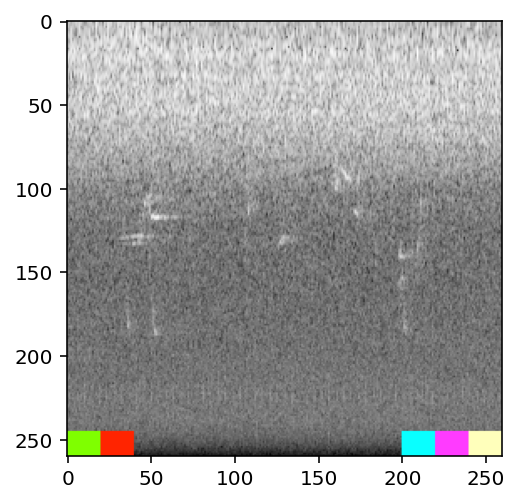

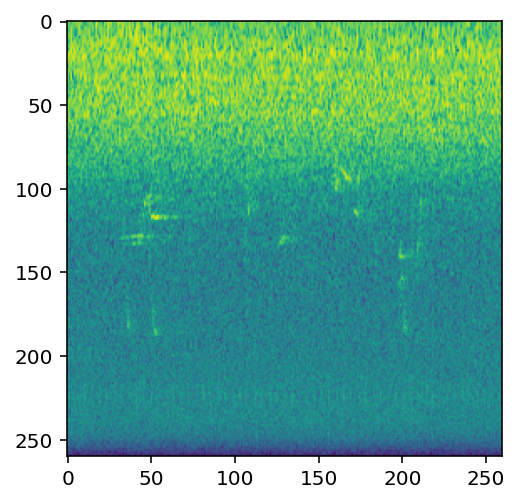

In [62]:
plt.imshow(list_mels_s[1][2][1])
plt.show();
plt.imshow(list_mels_s[0][:, 520:780])
plt.show();

# boost_multiple_occurences

In [66]:
pred_df=pd.read_csv('/app/_data/prediction_test.csv', index_col=[0])

In [64]:
def boost_multiple_occurences(
    df,
    labels,
    pred_col="y_pred",
    out_col="y_pred",
    boost_coef=2.4,
    max_boost_coef=24,
    threshold=0.5,
):
    """
    Boost predictions in file:
        - if something occured once, multiply that class by boost_coef
        - if something occured more than once - keep multiplying until
            boost_coef reaches max_boost_coef
    """

    def _compute_boost_matrix(
        y_preds, labels, threshold, boost_coef, max_boost_coef
    ):

        nocall_ix = labels.index("nocall")
        boost_matrix = np.ones((len(labels)), dtype=np.float64)
        for p in y_preds:
            p = np.fromstring(p, dtype=float, sep=' ')
            boost_matrix = boost_matrix * np.where(p > threshold, boost_coef, 1.0)
            boost_matrix = np.clip(boost_matrix, 1.0, max_boost_coef)
            boost_matrix[nocall_ix] = 1.0
        return boost_matrix

    res_df = pd.DataFrame()

    for filename in set(df["filename"]):  # type: ignore
        file_df = df[df.filename == filename]
        file_y_preds = file_df[pred_col].values
        bm = _compute_boost_matrix(
            file_y_preds,
            labels=labels,
            threshold=threshold,
            boost_coef=boost_coef,
            max_boost_coef=max_boost_coef,
        )

        file_y_preds = bm * file_y_preds

        file_df[out_col] = list(map(lambda x: x, file_y_preds))
        res_df = res_df.append(file_df)

    return res_df.reset_index(drop=True)

In [153]:
pred_df=pd.read_csv('/app/_data/prediction_test.csv', index_col=[0])
labels = list(dict_birds.keys())
nocall_ix = labels.index("nocall")

In [154]:
boost_matrix = np.ones((len(labels)), dtype=np.float64)
boost_coef = 2.4
pred_df['y_pred'] = pred_df['y_pred'].str.replace(r'[\[\]]', '')
y_preds = pred_df['y_pred'].values
max_boost_coef=24,

<ipython-input-154-d9ed925796ba>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_df['y_pred'] = pred_df['y_pred'].str.replace(r'[\[\]]', '')


In [ ]:
for p in y_preds:
    p = np.fromstring(p, dtype=float, sep=' ')
    boost_matrix = boost_matrix * np.where(p > threshold, boost_coef, 1.0)
    boost_matrix = np.clip(boost_matrix, 1.0, max_boost_coef)
    boost_matrix[nocall_ix] = 1.0

In [159]:
p = np.fromstring(y_preds[555], dtype=float, sep=' ')
boost_matrix = boost_matrix * np.where(p > 0.5, boost_coef, 1.0)

In [160]:
boost_matrix = np.clip(boost_matrix, 1.0, max_boost_coef)

In [179]:
def _compute_boost_matrix(
    y_preds, labels, threshold, boost_coef, max_boost_coef
):

    nocall_ix = labels.index("nocall")
    boost_matrix = np.ones((len(labels)), dtype=np.float64)
    for p in y_preds:
        p = np.fromstring(p, dtype=float, sep=' ')
        boost_matrix = boost_matrix * np.where(p > threshold, boost_coef, 1.0)
        boost_matrix = np.clip(boost_matrix, 1.0, max_boost_coef)
        boost_matrix[nocall_ix] = 1.0
    return boost_matrix

In [182]:
res_df = pd.DataFrame()

for filename in set(pred_df["filename"]):  # type: ignore
    file_df = pred_df[pred_df.filename == filename]
    file_y_preds = file_df['y_pred'].values
    bm = _compute_boost_matrix(
        file_y_preds,
        labels=labels,
        threshold=0.5,
        boost_coef=boost_coef,
        max_boost_coef=max_boost_coef,
    )
    print(bm)

#     file_y_preds = bm * file_y_preds

#     file_df[out_col] = list(map(lambda x: x, file_y_preds))
#     res_df = res_df.append(file_df)

[ 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  5.76   1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.    13.824  1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.  

In [181]:
bm

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

# generator for waves cut

In [13]:
class Mel_Provider:
    def __init__(
        self,
        n_fft,
        win_length,
        n_mels,
        sample_rate,
        mel_image_size,
        min_frequency,
        max_frequency,
        signal_lenght,
        hop_length=None,
        norm_mel=True,
        device="cpu",
    ):
        self.norm_mel = norm_mel
        self._device = device
        self.signal_lenght = signal_lenght
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        if hop_length is None:
            self.hop_length = int(
                self.signal_lenght * self.sample_rate / (self.mel_image_size - 1)
            )
        else:
            self.hop_length = hop_length
        self._melspectrogram = torchaudio.transforms.MelSpectrogram(
            power=2.0,
            win_length=win_length,
            n_fft=n_fft,
            n_mels=n_mels,
            sample_rate=sample_rate,
            hop_length=self.hop_length,
            f_min=min_frequency,
            f_max=max_frequency,
        ).to(self._device)

    def msg(self, wave):
        wave = torch.tensor(wave.reshape([1, -1]).astype(np.float32)).to(self._device)
        mel_spec = self._melspectrogram(wave)[0].cpu().numpy()
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        if self.norm_mel:
            mel_spec = (mel_spec - mel_spec.min()) / (
                mel_spec.max() - mel_spec.min()
            )
        mel_spec.astype(np.float32)
        return mel_spec

class Test_Kaggle:
    def __init__(
        self,
        path,
        df_coord_sites,
        dict_birds,
        n_fft,
        sample_rate,
        mel_image_size,
        signal_lenght,
        mel_provider, 
        hop_length=None,
        device="cpu",
    ):
        self.path = path
        self._device = device
        self.signal_lenght = signal_lenght
        self.sample_rate = sample_rate
        self.mel_image_size = mel_image_size
        self.hop_length = int(
            self.signal_lenght * self.sample_rate / (self.mel_image_size - 1)
        )
        self.mel_provider = mel_provider
        self.n_fft = n_fft
        self.df_coord_sites = df_coord_sites
        self.dict_birds = dict_birds

    def make_df(self):
        path = self.path
        list_files = []
        for filename in os.listdir(path):
            if filename.split(".")[-1] == "ogg":
                list_files.append(filename)
                call, srt = librosa.load(path + filename, sr=self.sample_rate)
                duration = librosa.get_duration(
                    call,
                    sr=self.sample_rate,
                    n_fft=self.n_fft,
                    hop_length=int(
                        self.signal_lenght
                        * self.sample_rate
                        / (self.mel_image_size - 1)
                    ),
                )
        df = pd.DataFrame()
        for filename in list_files:
            df.loc[filename, "filename"] = filename
            df.loc[filename, "audio_id"] = filename.split("_")[0]
            df.loc[filename, "site"] = filename.split("_")[1]
            df.loc[filename, "date"] = filename.split("_")[2].split(".")[0]
            df.loc[filename, "duration"] = duration
        df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
        df["month"] = df["date"].dt.month
        df["year"] = df["date"].dt.year
        df = df.merge(self.df_coord_sites, on="site", how="left")
        df["sin_month"] = np.sin(2 * np.pi * df["month"] / 12)
        df["cos_month"] = np.cos(2 * np.pi * df["month"] / 12)
        df["sin_longitude"] = np.sin(2 * np.pi * (df["longitude"]) / 360)
        df["cos_longitude"] = np.cos(2 * np.pi * (df["longitude"]) / 360)
        df["norm_latitude"] = (df["latitude"] + 90) / 180
        df["audio_id"] = df["audio_id"].astype("int")
        return df

    def get_audio(self, file_path, end_sec=None):
        wave, sr = librosa.load(file_path, sr=self.sample_rate)
        if end_sec is not None:
            end = int(end_sec*self.sample_rate)
            end = end if end<len(wave) else len(wave)
            start = int(end-(5*self.sample_rate))
            wave = wave[start:end]
        return wave


    def make_prediction(self, df, model, thresh=0.5, predict=True, return_mels=False):
        path = self.path
        pred_df = pd.DataFrame(columns=["filename", "row_id", "y_pred", "birds"])
        pred_df["y_pred"] = pred_df["y_pred"].astype("object")
        predictions = {}
        for ix in df.index.tolist():
            wave_name = df.loc[ix, "filename"]
            audio_id = df.loc[ix, "audio_id"]
            site = df.loc[ix, "site"]
            list_mels = []
            for end_sec in range(
                5, int(df.loc[ix, "duration"]) + 1, self.signal_lenght
            ):
                wave = self.get_audio(path + wave_name, end_sec)
                mel_spec = self.mel_provider.msg(wave)
                row_id = "_".join([str(audio_id), site, str(end_sec)])                
                mel_short = mel_spec * 255
                if mel_short.shape != (self.mel_image_size, self.mel_image_size):
                    mel_short = Image.fromarray(mel_short)
                    mel_short = mel_short.resize(
                        (self.mel_image_size, self.mel_image_size),
                        Image.BICUBIC,
                    )
                    mel_short = np.array(mel_short)
                mel_short = np.repeat(
                    np.expand_dims(mel_short.astype(np.uint8), 2), 3, 2
                )
                mel_short[self.mel_image_size - 15 :, :20, 0] = (
                    255 * df.loc[ix, "sin_month"]
                )
                mel_short[self.mel_image_size - 15 :, :20, 1] = 255
                mel_short[self.mel_image_size - 15 :, :20, 2] = 0
                mel_short[self.mel_image_size - 15 :, 20:40, 0] = 255
                mel_short[self.mel_image_size - 15 :, 20:40, 1] = (
                    255 * df.loc[ix, "cos_month"]
                )
                mel_short[self.mel_image_size - 15 :, 20:40, 2] = 0
                mel_short[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 60 : self.mel_image_size - 40,
                    0,
                ] = (
                    255 * df.loc[ix, "sin_longitude"]
                )
                mel_short[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 60 : self.mel_image_size - 40,
                    1,
                ] = 255
                mel_short[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 60 : self.mel_image_size - 40,
                    2,
                ] = 255
                mel_short[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 40 : self.mel_image_size - 20,
                    0,
                ] = 255
                mel_short[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 40 : self.mel_image_size - 20,
                    1,
                ] = (
                    255 * df.loc[ix, "cos_longitude"]
                )
                mel_short[
                    self.mel_image_size - 15 :,
                    self.mel_image_size - 40 : self.mel_image_size - 20,
                    2,
                ] = 255
                mel_short[
                    self.mel_image_size - 15 :, self.mel_image_size - 20 :, 0
                ] = 255
                mel_short[
                    self.mel_image_size - 15 :, self.mel_image_size - 20 :, 1
                ] = 255
                mel_short[self.mel_image_size - 15 :, self.mel_image_size - 20 :, 2] = (
                    255 * df.loc[ix, "norm_latitude"]
                )
                list_mels.append({row_id:mel_short})

                if predict:
                    mel_short = tf.expand_dims(mel_short, axis=0)
                    pred = model.predict(mel_short)[0]
                    list_birds = " ".join(
                        [
                            self.dict_birds[i]
                            for i in range(len(self.dict_birds))
                            if pred[i] > thresh
                        ]
                    )
                    pred_df.loc[row_id, "filename"] = wave_name
                    pred_df.loc[row_id, "row_id"] = row_id
                    pred_df.loc[row_id, "y_pred"] = np.array(pred)
                    pred_df.loc[row_id, "birds"] = list_birds
                    predictions[row_id] = pred
        if predict:
            return pred_df, predictions
        if return_mels:
            return list_mels

    def boost_multiple_occurences(
        df,
        labels,
        pred_col="y_pred",
        out_col="y_pred",
        boost_coef=2.4,
        max_boost_coef=24,
        threshold=0.5,
    ):
        """
        Boost predictions in file:
            - if something occured once, multiply that class by boost_coef
            - if something occured more than once - keep multiplying until
                boost_coef reaches max_boost_coef
        """

        def _compute_boost_matrix(
            y_preds, labels, threshold, boost_coef, max_boost_coef
        ):

            nocall_ix = labels.index("nocall")
            boost_matrix = np.ones((len(labels)), dtype=np.float64)
            for p in y_preds:
                boost_matrix = boost_matrix * np.where(p > threshold, boost_coef, 1.0)
                boost_matrix = np.clip(boost_matrix, 1.0, max_boost_coef)
                boost_matrix[nocall_ix] = 1.0

            return boost_matrix

        res_df = pd.DataFrame()

        for filename in set(df["filename"]):  # type: ignore

            file_df = df[df.filename == filename]
            file_y_preds = np.stack(file_df[pred_col].values, axis=0)
            bm = _compute_boost_matrix(
                file_y_preds,
                labels=labels,
                threshold=threshold,
                boost_coef=boost_coef,
                max_boost_coef=max_boost_coef,
            )

            file_y_preds = bm * file_y_preds

            file_df[out_col] = list(map(lambda x: x, file_y_preds))
            res_df = res_df.append(file_df)

        return res_df.reset_index(drop=True)

In [14]:
msg_provider = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
)

In [15]:
tk = Test_Kaggle(
    path=TRAIN_AUDIO_PATH,
    df_coord_sites = coord_sites,
    mel_provider=msg_provider,
    dict_birds = dict_birds_code,
    n_fft=N_FFT,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    signal_lenght=SIGNAL_LENGTH,
    hop_length=None,
    device="cpu",
)

In [7]:
df = tk.make_df()

In [16]:
list_mels =tk.make_prediction(df.head(1), model=None, predict=False, return_mels=True)

In [20]:
import matplotlib.pyplot as plt

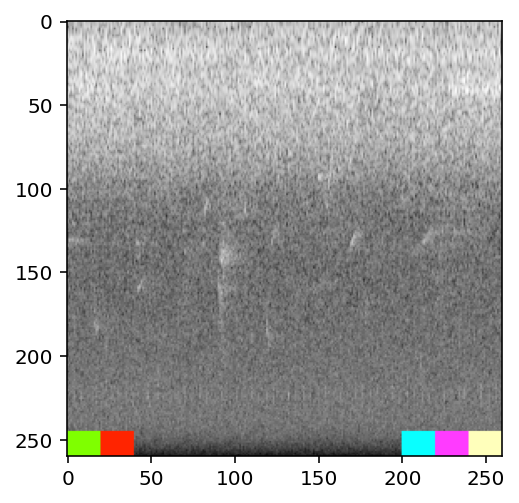

In [30]:
plt.imshow(list_mels[10]['51010_SSW_55'])